<h1>Angela Barriga - Assignment 2</h1>

<h2>Task 1</h2>

For this task I have chosen a deep convolutional network. I follow the usual architecture for a convolutional network:  several blocks of convolutional, relu and pool layers that merges the images to a smaller size. I introduce into each CONV-RELU-POOL block a dropout layer to reduce the number of parameters. The network finishes with a flatten later and two fully connected layers, which output goes into six softmax layers, the first one to classify how many digits are in the image and the next five ones to classify each digit (there's a maximum of five digits per image).

I process the data so that I work with images cropped by their outter bounding box (this is a bounding box containing all bounding boxes in the image). This way, it is easier to recognize each digit since there will be no unnecessary information in the image (all digits are in a row). Since I work to predict 5 digits per image, if there are less digits I put '10' in the labels to identify 'no digit'.

I use the dataset in format 1 from: http://ufldl.stanford.edu/housenumbers/ (before knowing that it was mandatory to work with format 1 I solved the problem with format 2 with a really simple convolutional network, but it was really similar to what I did for Ex1, so I don't find interesting to attach the code). From this dataset, I only use train and test, not the extra data. I use one twelfth of the training dataset for validation.

The training dataset is enriched by adding random crops from the digits (see getRandomSmaller). After training during 10 epochs my accuracy is an average of 91% in the test dataset, getting a maximum of 99% accuracy in the fifth digit and a minimum of 85% in the second one.

<h3>
    References
</h3>
Links that have helped me to do this task:

<ul>
<li>https://github.com/thomalm/svhn-multi-digit/blob/master/06-svhn-multi-model.ipynb</li>
<li>https://stackoverflow.com/questions/41176258/h5py-access-data-in-datasets-in-svhn</li>
<li>https://github.com/SaiKiranAvuthu/Multi_Digit_recognition_SVHN/</li>
<li>https://github.com/spotofleopard/Keras_SVHN/</li>
<li>https://github.com/potterhsu/SVHNClassifier</li>
<li>https://github.com/daQuincy/Street_View_House_Numbers</li>
<li>https://github.com/mgruben/digit-recognition</li>
<li>http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf</li>
<li>https://agi.io/2018/01/31/getting-started-street-view-house-numbers-svhn-dataset/</li>
</ul>

In [3]:
import os
import cv2
import h5py
import math
import numpy as np
from PIL import Image
from scipy import misc
import random as rand
from operator import add
import pickle
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.patches

# Data is saved from the folders and .mat file to pickle files for easier management

def readAndSaveMetadata(train=True):
    if train:
        directory =  "/home/angelaBR/data/train/"
        fn = "train_metadata.pickle"
    else:
        directory =  "/home/angelaBR/data/test/"
        fn = "test_metadata.pickle"
    
    f = h5py.File(directory + 'digitStruct.mat', 'r') 
    
    metadata= {}
    metadata['height'] = []
    metadata['label'] = []
    metadata['left'] = []
    metadata['top'] = []
    metadata['width'] = []
    
    def print_attrs(name, obj):
        vals = []
        if obj.shape[0] == 1:
            vals.append(obj[0][0])
        else:
            for k in range(obj.shape[0]):
                vals.append(f[obj[k][0]][0][0])
        metadata[name].append(vals)
    

    for item in f['/digitStruct/bbox']:
        f[item[0]].visititems(print_attrs)
    
    pickle_file = directory + fn
    try:
      pickleData = open(pickle_file, 'wb')
      pickle.dump(metadata, pickleData, pickle.HIGHEST_PROTOCOL)
      pickleData.close()
    except Exception as e:
      print('Unable to save data to', pickle_file, ':', e)
      raise

readAndSaveMetadata(train=True)
readAndSaveMetadata(train=False)

In [25]:
training_directory = "/home/angelaBR/data/train/"
testing_directory = "/home/angelaBR/data/test/"

testing_filenames = []
training_filenames = []

# Load data into different arrays

for i in range(1, 33403):
    training_filenames.append(str(i)+'.png')
    
for i in range(1, 13069):
    testing_filenames.append(str(i)+'.png')
    
def loadMetadata(train=True):
    if train:
        directory = training_directory
        fn = 'train_metadata.pickle'
    else:
        directory = testing_directory
        fn = 'test_metadata.pickle'
    f = open(directory + fn, 'rb')
    return pickle.load(f)

training_metadata = loadMetadata(train=True)
testing_metadata = loadMetadata(train=False)

train_l = len(training_metadata['label'])
test_l = len(testing_metadata['label'])

# Gets bounding box from the labels
def getBBox(i, train=True):
    
    if train:
        metadata = training_metadata
    else:
        metadata = testing_metadata
    
    x_min = min(metadata['left'][i-1])
    y_min = min(metadata['top'][i-1])
    x_max = max(map(add, metadata['left'][i-1], metadata['width'][i-1]))
    y_max = max(map(add, metadata['top'][i-1], metadata['height'][i-1]))
    return x_min, y_min, x_max, y_max

# Expands bounding box by a 30% in each axis, better for accuracy
def expandBBox(x_min, y_min, x_max, y_max):
    
    x_d = ((x_max - x_min) * 0.3) // 2
    y_d = ((y_max - y_min) * 0.3) // 2
    return x_min - x_d, y_min - y_d, x_max + x_d, y_max + y_d

# Crops image through its bounding box
def cropBBox(img, x_min, y_min, x_max, y_max):
    
    x_min = max(0, x_min)
    y_min = max(0, y_min)
    x_max = min(img.shape[1], x_max)
    y_max = min(img.shape[0], y_max)
    return int(x_min), int(y_min), int(x_max), int(y_max)

def getResized(f, train=True):
    
    img = mpimg.imread(f)
    
    # Get the file number without the path
    if train:
        i = int(f.name[26:].split('.')[0])
    else:
        i = int(f.name[25:].split('.')[0])

    # Crops bbox
    x_min, y_min, x_max, y_max = cropBBox(img, *expandBBox(*getBBox(i, train)))
    
    # Return a cropped and resized image
    if train:
        cropped = img[y_min:y_max, x_min:x_max]
        return cv2.resize(cropped, (64, 64))
    else:
        cropped = img[y_min:y_max, x_min:x_max]
        return cv2.resize(cropped, (54, 54))

# Random crop from the image, to train with more variety
def getRandomSmaller(img):
    
    x_min = rand.randint(0,10)
    x_max = 64 - (10 - x_min)
    y_min = rand.randint(0,10)
    y_max = 64 - (10 - y_min)
    return img[y_min:y_max, x_min:x_max]
    
# Substracts mean of a img
def subtractMean(img):
   
    return img - np.mean(img)

# Creates data with cropped images by their outter bbox
def createAndSaveData(train=True, num_random_subsamples=5):
    im_array = []
    fn = "54x54.npy"
    
    if train:
        directory =  "/home/angelaBR/data/train/"
        filenames = training_filenames
    else:
        directory =  "/home/angelaBR/data/test/"
        filenames = testing_filenames
        
    for i in filenames:
        with open(directory + i, 'rb') as f:
            img = getResized(f, train)
            if train:
                for j in range(num_random_subsamples):
                    im_array.append(subtractMean(getRandomSmaller(img)))
            else:
                im_array.append(subtractMean(img))
    np.save(directory + fn, im_array)
    
createAndSaveData(train=True)
createAndSaveData(train=False)


# Save labels for each digit and length
def saveLabels(train=True, num_random_subsamples=5):
    
    if train:
        directory = training_directory
        metadata = training_metadata
        l = train_l
    else:
        directory = testing_directory
        metadata = testing_metadata
        l = test_l
    
    # Labels for each output (length + 5 digits)
    r0 = []
    r1 = []
    r2 = []
    r3 = []
    r4 = []
    r5 = []
    for i in range(0, l):
        a = metadata['label'][i]
        label = [len(a)]
        for n in a:
            label.append(n)
        while len(label) < 6:
            label.append(10)
        if train:
            for j in range(num_random_subsamples):
                r0.append(label[0])
                r1.append(label[1])
                r2.append(label[2])
                r3.append(label[3])
                r4.append(label[4])
                r5.append(label[5])
        else:
            r0.append(label[0])
            r1.append(label[1])
            r2.append(label[2])
            r3.append(label[3])
            r4.append(label[4])
            r5.append(label[5])
    
    for i, r in enumerate([r0,r1,r2,r3,r4,r5]):
        np.save(directory + 'labels' + str(i) + '.npy', r)

saveLabels(train=True)
saveLabels(train=False)

In [33]:
from keras.utils import to_categorical

# Data to numpy arrays

x_train = np.load('/home/angelaBR/data/train/54x54.npy')
x_test = np.load('/home/angelaBR/data/test/54x54.npy')

y0_train = np.load('/home/angelaBR/data/train/labels0.npy')
y1_train = np.load('/home/angelaBR/data/train/labels1.npy')
y2_train = np.load('/home/angelaBR/data/train/labels2.npy')
y3_train = np.load('/home/angelaBR/data/train/labels3.npy')
y4_train = np.load('/home/angelaBR/data/train/labels4.npy')
y5_train = np.load('/home/angelaBR/data/train/labels5.npy')

y0_test = np.load('/home/angelaBR/data/test/labels0.npy')
y1_test = np.load('/home/angelaBR/data/test/labels1.npy')
y2_test = np.load('/home/angelaBR/data/test/labels2.npy')
y3_test = np.load('/home/angelaBR/data/test/labels3.npy')
y4_test = np.load('/home/angelaBR/data/test/labels4.npy')
y5_test = np.load('/home/angelaBR/data/test/labels5.npy')

# One-hot encoding for labels

y0_train = to_categorical(y0_train, 7)
y1_train = to_categorical(y1_train, 11)
y2_train = to_categorical(y2_train, 11)
y3_train = to_categorical(y3_train, 11)
y4_train = to_categorical(y4_train, 11)
y5_train = to_categorical(y5_train, 11)

y0_test = to_categorical(y0_test, 7)
y1_test = to_categorical(y1_test, 11)
y2_test = to_categorical(y2_test, 11)
y3_test = to_categorical(y3_test, 11)
y4_test = to_categorical(y4_test, 11)
y5_test = to_categorical(y5_test, 11)

y_test = [y0_test, y1_test, y2_test, y3_test, y4_test, y5_test]
y_train = [y0_train, y1_train, y2_train, y3_train, y4_train, y5_train]

In [1]:
from keras.callbacks import TensorBoard
from keras.layers import Input, Convolution2D, MaxPooling2D, Dropout, Flatten, MaxoutDense
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Activation, Dense
from keras.models import Model
from keras.optimizers import SGD

img_channels = 3
img_rows = 54
img_cols = 54

# Layer 0: Input
x = Input((img_rows, img_cols, img_channels))

# Layer 1: 48-unit maxout convolution
y = Convolution2D(nb_filter = 48, nb_row = 5, nb_col = 5, border_mode="same", name="1conv")(x)
y = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), border_mode="same", name="1maxpool")(y)
y = Dropout(0.25, name="1drop")(y)
y = Activation('relu', name="1activ")(y)

# Layer 2: 64-unit relu convolution
y = Convolution2D(nb_filter = 64, nb_row = 5, nb_col = 5, border_mode="same", name="2conv")(y)
y = MaxPooling2D(pool_size = (2, 2), strides = (1, 1), border_mode="same", name="2maxpool")(y)
y = Dropout(0.25, name="2drop")(y)
y = Activation('relu', name="2activ")(y)

# Layer 3: 128-unit relu convolution
y = Convolution2D(nb_filter = 128, nb_row = 5, nb_col = 5, border_mode="same", name="3conv")(y)
y = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), border_mode="same", name="3maxpool")(y)
y = Dropout(0.25, name="3drop")(y)
y = Activation('relu', name="3activ")(y)

# Layer 4: 160-unit relu convolution
y = Convolution2D(nb_filter = 160, nb_row = 5, nb_col = 5, border_mode="same", name="4conv")(y)
y = MaxPooling2D(pool_size = (2, 2), strides = (1, 1), border_mode="same", name="4maxpool")(y)
y = Dropout(0.25, name="4drop")(y)
y = Activation('relu', name="4activ")(y)

# Layer 5: 192-unit relu convolution
y = Convolution2D(nb_filter = 192, nb_row = 5, nb_col = 5, border_mode="same", name="5conv")(y)
y = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), border_mode="same", name="5maxpool")(y)
y = Dropout(0.25, name="5drop")(y)
y = Activation('relu', name="5activ")(y)

# Layer 6: 192-unit relu convolution
y = Convolution2D(nb_filter = 192, nb_row = 5, nb_col = 5, border_mode="same", name="6conv")(y)
y = MaxPooling2D(pool_size = (2, 2), strides = (1, 1), border_mode="same", name="6maxpool")(y)
y = Dropout(0.25, name="6drop")(y)
y = Activation('relu', name="6activ")(y)

# Layer 7: 192-unit relu convolution
y = Convolution2D(nb_filter = 192, nb_row = 5, nb_col = 5, border_mode="same", name="7conv")(y)
y = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), border_mode="same", name="7maxpool")(y)
y = Dropout(0.25, name="7drop")(y)
y = Activation('relu', name="7activ")(y)

# Layer 8: 192-unit relu convolution
y = Convolution2D(nb_filter = 192, nb_row = 5, nb_col = 5, border_mode="same", name="8conv")(y)
y = MaxPooling2D(pool_size = (2, 2), strides = (1, 1), border_mode="same", name="8maxpool")(y)
y = Dropout(0.25, name="8drop")(y)
y = Activation('relu', name="8activ")(y)

# Layer 9: Flatten
y = Flatten()(y)

# Layer 10: Fully-Connected Layer
y = Dense(3072, activation=None, name="fc1")(y)

# Layer 11: Fully-Connected Layer
y = Dense(3072, activation=None, name="fc2")(y)

length = Dense(7, activation="softmax", name="length")(y)
digit1 = Dense(11, activation="softmax", name="digit1")(y)
digit2 = Dense(11, activation="softmax", name="digit2")(y)
digit3 = Dense(11, activation="softmax", name="digit3")(y)
digit4 = Dense(11, activation="softmax", name="digit4")(y)
digit5 = Dense(11, activation="softmax", name="digit5")(y)

model = Model(input=x, output=[length, digit1, digit2, digit3, digit4, digit5])
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['categorical_accuracy'])

# One twelfth of train dataset to validation 
model.fit(x_train,  y_train, nb_epoch=10, batch_size=200, verbose=1, validation_split=1/12.)

Train on 153092 samples, validate on 13918 samples
Epoch 1/10
153092/153092 [==============================] - 61s 400us/step - loss: 6.7451 - length_loss: 1.0701 - digit1_loss: 2.0395 - digit2_loss: 2.1993 - digit3_loss: 1.1496 - digit4_loss: 0.2549 - digit5_loss: 0.0313 - length_categorical_accuracy: 0.5477 - digit1_categorical_accuracy: 0.2724 - digit2_categorical_accuracy: 0.2478 - digit3_categorical_accuracy: 0.7341 - digit4_categorical_accuracy: 0.9621 - digit5_categorical_accuracy: 0.9984 - val_loss: 6.3796 - val_length_loss: 0.8511 - val_digit1_loss: 2.0166 - val_digit2_loss: 2.1558 - val_digit3_loss: 1.0815 - val_digit4_loss: 0.2534 - val_digit5_loss: 0.0194 - val_length_categorical_accuracy: 0.6372 - val_digit1_categorical_accuracy: 0.2729 - val_digit2_categorical_accuracy: 0.2464 - val_digit3_categorical_accuracy: 0.7354 - val_digit4_categorical_accuracy: 0.9630 - val_digit5_categorical_accuracy: 0.9996
Epoch 2/10
153092/153092 [==============================] - 60s 395us/st

153092/153092 [==============================] - 61s 397us/step - loss: 1.0489 - length_loss: 0.1093 - digit1_loss: 0.2915 - digit2_loss: 0.3434 - digit3_loss: 0.2305 - digit4_loss: 0.0723 - digit5_loss: 0.0019 - length_categorical_accuracy: 0.9622 - digit1_categorical_accuracy: 0.9087 - digit2_categorical_accuracy: 0.8916 - digit3_categorical_accuracy: 0.9265 - digit4_categorical_accuracy: 0.9782 - digit5_categorical_accuracy: 0.9997 - val_loss: 1.0006 - val_length_loss: 0.1138 - val_digit1_loss: 0.2807 - val_digit2_loss: 0.3247 - val_digit3_loss: 0.2154 - val_digit4_loss: 0.0663 - val_digit5_loss: 0.0028 - val_length_categorical_accuracy: 0.9621 - val_digit1_categorical_accuracy: 0.9174 - val_digit2_categorical_accuracy: 0.9016 - val_digit3_categorical_accuracy: 0.9373 - val_digit4_categorical_accuracy: 0.9817 - val_digit5_categorical_accuracy: 0.9996


In [47]:
results = model.evaluate(x_test, y_test, verbose=1)

print('loss: {:0.4f}'. format(results[0]))

print('length_loss: {:0.4f}'. format(results[1]))
print('digit1_loss: {:0.4f}'. format(results[2]))
print('digit2_loss: {:0.4f}'. format(results[3]))
print('digit3_loss: {:0.4f}'. format(results[4]))
print('digit4_loss: {:0.4f}'. format(results[5]))
print('digit5_loss: {:0.4f}'. format(results[6]))

print('length_acc: {:0.4f}'. format(results[7]))
print('digit1_acc: {:0.4f}'. format(results[8]))
print('digit2_acc: {:0.4f}'. format(results[9]))
print('digit3_acc: {:0.4f}'. format(results[10]))
print('digit4_acc: {:0.4f}'. format(results[11]))
print('digit5_acc: {:0.4f}'. format(results[12]))

loss = results[1:6]
acc = results[7:12]

print('AVERAGE LOSS: {:0.4f}' . format(sum(loss) / len(loss)) )
print('AVERAGE ACCURACY: {:0.4f}'. format(sum(acc) / len(acc)) )


13068/13068 [==============================] - 5s 371us/step
loss: 1.3766
length_loss: 0.2510
digit1_loss: 0.3651
digit2_loss: 0.4569
digit3_loss: 0.2517
digit4_loss: 0.0496
digit5_loss: 0.0016
length_acc: 0.9080
digit1_acc: 0.8894
digit2_acc: 0.8598
digit3_acc: 0.9266
digit4_acc: 0.9881
digit5_acc: 0.9999
AVERAGE LOSS: 0.2749
AVERAGE ACCURACY: 0.9144


<h2>Task 2</h2>

For this task I use the fish_generation code to generate my own dataset. My images have a maximum of 4 fishes. 
This task was quite difficult for me, it took me a long time to finish and I tried to solve it with different approaches.

<h3>
    Approaches
</h3>

<ul>
    <li>1. Using the same approach as for Task 1 with the same model, adapting some parts to the new data. I got poor accuracy, 20% of average.</li>
    <li>2. Following what was written in this paper: http://courses.washington.edu/fish538/resources/Allken%20et%20al%202018.pdf and combining it with the approach in Task1 I used as a model a InceptionV3 with pre-trained weights from the ImageNet dataset. Within this approach I tried different modifications that I detail below. I didn't have much success with any of them, but the accuracy was better than in the previous point. I attach the code for the best solution of this approach at the end of the notebook (see Failed approach), with an average accuracy of 48%.</li>
    <ul>
        <li>a) Tested with a without data generators.</li>
        <li>b) With a without data augmentation.</li>
        <li>c) With SGD and RMSprop optimizers.</li>
        <li>d) With different amounts of data, from 1000 to 4000 samples in total. I could not work with more data due to memory errors.</li>
        <li>e) Stacking from 1 to 4 dense layers at the end of the pre-trained Inception.</li>
    </ul>
    <li>3. Thanks to Pierre instructions, I finally managed to get a good solution (0.158238 average loss) by using this version of YOLO-v3: Darknet https://github.com/AlexeyAB/darknet. I was not able to execute it through jupyter notebook, but I add here all the commands I used and some pictures depicting the process. For using this, I had to do some modifications in the dataset generation: </li>
    <ul>
        <li>a) I worked with 800 samples for the train dataset and 100 for the test. I know these are small numbers but data generation took a long time and I couldn't spend more time just in generating data, since I needed to test the network and finish this notebook. Also, I saw that the network was able to work with not so many samples (400 in this example https://www.datascienceauthority.com/post/blood-cells-detection-with-yolov3).</li>
        <li>b) The YOLO format, as far as I could see, does not accept negative coordinates, therefore I had to modify the generation so that fishes were not localized out of bound in the image (fishes partially visible, for example, half of the body, would have x and y coordinates with negative values).</li>
        <li>c) I had to translate the x, y, width and height to YOLO coordinates, which are relative to the images (for instance, x = x/images_width, width = width/image_width, etc).</li>
        <li>d) The generator would create labals starting with the name of each class (Herring, Mackerel...). I deleted this first field and modified the id of each class so that they were between 0 and 3 (1 and 4 before).</li>
    </ul>
</ul>

<h3>
    Description of the YOLO-v3
</h3>

In this model, a single neural network is aplied to the full image. The YOLO network network divides the image into regions and predicts bounding boxes and probabilities for each region. These bounding boxes are weighted by the predicted probabilities. YOLO looks at the whole image at test time so its predictions are informed by global context in the image. 


<h3>
    References
</h3>
Some references that helped me with this task:
<ul>
<li>https://pjreddie.com/media/files/papers/YOLOv3.pdf</li>
<li> https://riptutorial.com/tensorflow/example/27789/how-to-load-images-and-labels-from-a-txt-file</li>
<li>https://github.com/AlexeyAB/darknet</li>
<li>https://www.datascienceauthority.com/post/blood-cells-detection-with-yolov3</li>
<li>https://github.com/ultralytics/yolov3/blob/master/examples.ipynb</li>
<li>https://blog.goodaudience.com/part-1-preparing-data-before-training-yolo-v2-and-v3-deepfashion-dataset-3122cd7dd884</li>
<li>http://courses.washington.edu/fish538/resources/Allken%20et%20al%202018.pdf</li>
<li>https://towardsdatascience.com/implementing-yolo-on-a-custom-dataset-20101473ce53</li>
<li>https://github.com/WyattAutomation/Train-YOLOv3-with-OpenImagesV </li>
</ul>


<h2>
Solution
</h2>
I trained the Darknet for around 10 hours during 8000 episodes. The training used some pretrained weights I could download in the Darknet tutorial. I executed with this command:

<code>./darknet detector train build/darknet/x64/data/classes-obj.data cfg/yolo-obj.cfg build/darknet/x64/darknet53.conv.74</code>

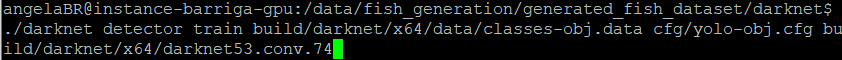
<br><br>
Final output: <br><br>

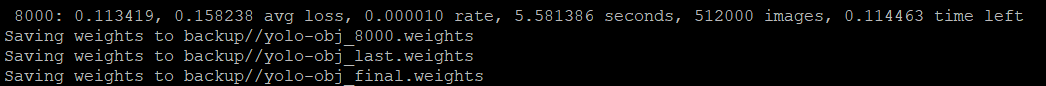
<br><br>
Then I proceeded to test the network with all samples in the test set:
<br><br>
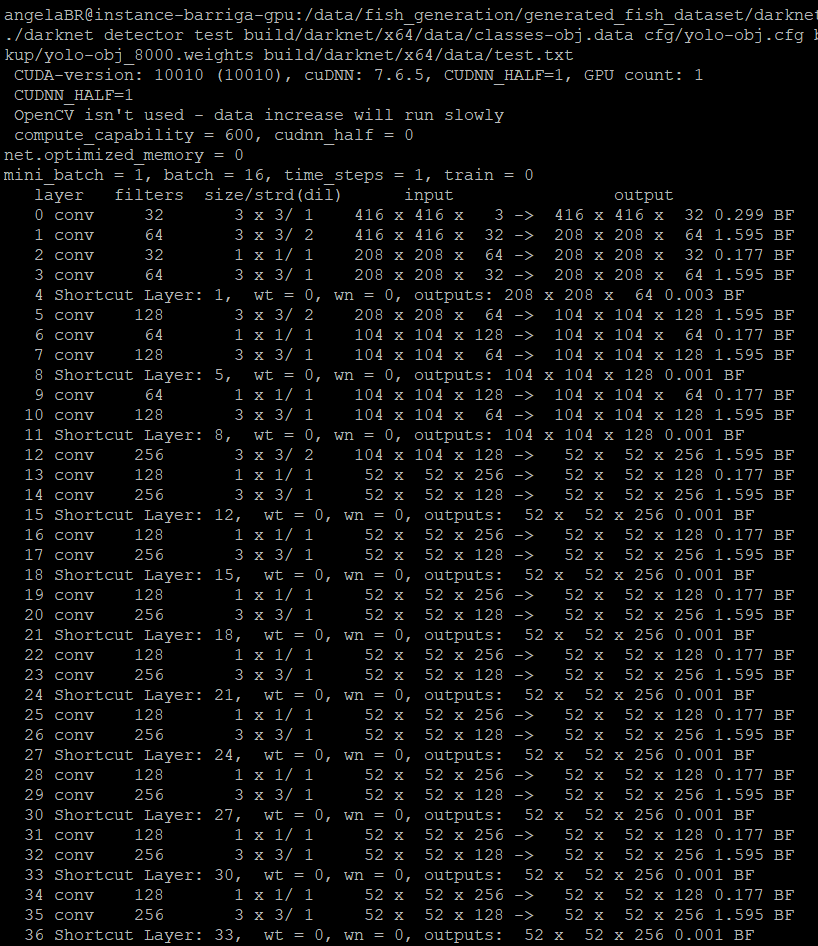
<br><br>
(more layers were displayed here, I don't show all of them for the sake of clarity).
<br><br>
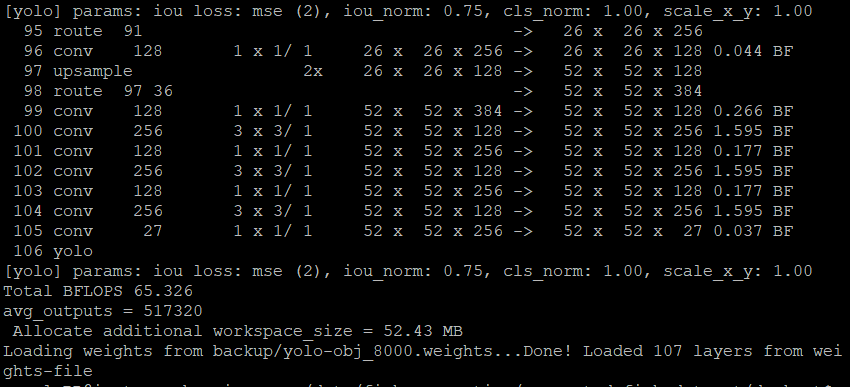
<br><br>

Next, I display the results stored in results.txt, including the classification for each file in the test dataset:

<code>CUDNN_HALF=1 <br>
net.optimized_memory = 0 <br>
mini_batch = 1, batch = 16, time_steps = 1, train = 0 <br>
<br>
seen 64, trained: 512 K-images (8 Kilo-batches_64) <br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_0.png: Predicted in 18.324000 milli-seconds.<br>
Benthosema: 87%<br>
Mackerel: 100%<br>
Herring: 40%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_10.png: Predicted in 17.988000 milli-seconds.<br>
Herring: 100%<br>
Benthosema: 99%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_11.png: Predicted in 17.999000 milli-seconds.<br>
Benthosema: 82%<br>
Mackerel: 100%<br>
BlueWhiting: 82%<br>
Mackerel: 98%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_12.png: Predicted in 18.080000 milli-seconds.<br>
BlueWhiting: 100%<br>
Benthosema: 99%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_13.png: Predicted in 18.112000 milli-seconds.<br>
BlueWhiting: 100%<br>
BlueWhiting: 56%<br>
BlueWhiting: 100%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_14.png: Predicted in 17.950000 milli-seconds.<br>
Herring: 96%<br>
Herring: 100%<br>
Benthosema: 100%<br>
Mackerel: 100%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_15.png: Predicted in 17.882000 milli-seconds.<br>
BlueWhiting: 100%<br>
Herring: 100%<br>
BlueWhiting: 97%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_16.png: Predicted in 17.996000 milli-seconds.<br>
Benthosema: 99%<br>
BlueWhiting: 97%<br>
BlueWhiting: 100%<br>
Mackerel: 100%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_17.png: Predicted in 17.854000 milli-seconds.<br>
BlueWhiting: 99%<br>
Herring: 100%<br>
BlueWhiting: 100%<br>
Herring: 100%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_18.png: Predicted in 17.757000 milli-seconds.<br>
Herring: 99%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_19.png: Predicted in 17.988000 milli-seconds.<br>
Herring: 100%<br>
Mackerel: 100%<br>
BlueWhiting: 30%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_1.png: Predicted in 18.137000 milli-seconds.<br>
Herring: 100%<br>
Herring: 43%<br>
Mackerel: 35%<br>
Herring: 99%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_20.png: Predicted in 17.968000 milli-seconds.<br>
Benthosema: 100%<br>
BlueWhiting: 100%<br>
Benthosema: 100%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_21.png: Predicted in 17.898000 milli-seconds.<br>
BlueWhiting: 96%<br>
Herring: 99%<br>
Mackerel: 100%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_22.png: Predicted in 17.815000 milli-seconds.<br>
BlueWhiting: 100%<br>
Mackerel: 100%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_23.png: Predicted in 17.738000 milli-seconds.<br>
Benthosema: 100%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_24.png: Predicted in 17.779000 milli-seconds.<br>
BlueWhiting: 97%<br>
Herring: 95%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_25.png: Predicted in 17.892000 milli-seconds.<br>
Herring: 100%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_26.png: Predicted in 17.791000 milli-seconds.<br>
Mackerel: 100%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_27.png: Predicted in 18.044000 milli-seconds.<br>
Benthosema: 99%<br>
Herring: 100%<br>
Mackerel: 99%<br>
Herring: 95%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_28.png: Predicted in 18.089000 milli-seconds.<br>
Herring: 100%<br>
Herring: 100%<br>
BlueWhiting: 100%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_29.png: Predicted in 17.932000 milli-seconds.<br>
Herring: 100%<br>
Herring: 99%<br>
Mackerel: 100%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_2.png: Predicted in 17.799000 milli-seconds.<br>
BlueWhiting: 93%<br>
BlueWhiting: 100%<br>
Benthosema: 100%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_30.png: Predicted in 17.860000 milli-seconds.<br>
Mackerel: 100%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_31.png: Predicted in 17.794000 milli-seconds.<br>
Mackerel: 100%<br>
BlueWhiting: 96%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_32.png: Predicted in 18.062000 milli-seconds.<br>
BlueWhiting: 98%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_33.png: Predicted in 17.847000 milli-seconds.<br>
BlueWhiting: 91%<br>
BlueWhiting: 100%<br>
Mackerel: 100%<br>
Benthosema: 100%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_34.png: Predicted in 17.628000 milli-seconds.<br>
Benthosema: 93%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_35.png: Predicted in 17.904000 milli-seconds.<br>
Benthosema: 100%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_36.png: Predicted in 17.878000 milli-seconds.<br>
BlueWhiting: 97%<br>
BlueWhiting: 40%<br>
Benthosema: 99%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_37.png: Predicted in 17.707000 milli-seconds.<br>
BlueWhiting: 100%<br>
BlueWhiting: 100%<br>
Herring: 100%<br>
Benthosema: 49%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_38.png: Predicted in 17.873000 milli-seconds.<br>
Benthosema: 84%<br>
BlueWhiting: 99%<br>
BlueWhiting: 80%<br>
Benthosema: 100%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_39.png: Predicted in 17.779000 milli-seconds.<br>
Mackerel: 72%<br>
Mackerel: 100%<br>
Benthosema: 100%<br>
Benthosema: 93%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_3.png: Predicted in 17.724000 milli-seconds.<br>
Mackerel: 100%<br>
BlueWhiting: 100%<br>
Herring: 100%<br>
Herring: 43%<br>
BlueWhiting: 40%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_40.png: Predicted in 17.938000 milli-seconds.<br>
Herring: 88%<br>
Mackerel: 81%<br>
Herring: 78%<br>
Mackerel: 98%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_41.png: Predicted in 17.982000 milli-seconds.<br>
Herring: 83%<br>
BlueWhiting: 99%<br>
Herring: 100%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_42.png: Predicted in 17.759000 milli-seconds.<br>
Benthosema: 95%<br>
BlueWhiting: 100%<br>
Herring: 99%<br>
Herring: 96%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_43.png: Predicted in 18.003000 milli-seconds.<br>
Benthosema: 100%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_44.png: Predicted in 17.818000 milli-seconds.<br>
Herring: 100%<br>
Mackerel: 98%<br>
Mackerel: 99%<br>
Herring: 100%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_45.png: Predicted in 18.085000 milli-seconds.<br>
Mackerel: 100%<br>
Herring: 93%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_46.png: Predicted in 17.873000 milli-seconds.<br>
Mackerel: 99%<br>
Mackerel: 98%<br>
Benthosema: 100%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_47.png: Predicted in 17.893000 milli-seconds.<br>
Benthosema: 100%<br>
Benthosema: 99%<br>
BlueWhiting: 100%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_48.png: Predicted in 17.659000 milli-seconds.<br>
BlueWhiting: 100%<br>
Herring: 95%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_49.png: Predicted in 17.905000 milli-seconds.<br>
Benthosema: 99%<br>
Mackerel: 100%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_4.png: Predicted in 18.059000 milli-seconds.<br>
Herring: 100%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_50.png: Predicted in 17.735000 milli-seconds.<br>
Benthosema: 91%<br>
Herring: 100%<br>
Herring: 100%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_51.png: Predicted in 17.845000 milli-seconds.<br>
BlueWhiting: 98%<br>
BlueWhiting: 100%<br>
Mackerel: 100%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_52.png: Predicted in 17.948000 milli-seconds.<br>
Herring: 100%<br>
Mackerel: 71%<br>
Herring: 99%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_53.png: Predicted in 17.836000 milli-seconds.<br>
Benthosema: 99%<br>
Benthosema: 92%<br>
Herring: 100%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_54.png: Predicted in 17.820000 milli-seconds.<br>
Mackerel: 97%<br>
Mackerel: 99%<br>
BlueWhiting: 91%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_55.png: Predicted in 17.874000 milli-seconds.<br>
BlueWhiting: 95%<br>
Benthosema: 99%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_56.png: Predicted in 17.841000 milli-seconds.<br>
Mackerel: 100%<br>
Herring: 96%<br>
Mackerel: 100%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_57.png: Predicted in 17.893000 milli-seconds.<br>
Benthosema: 100%<br>
Herring: 99%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_58.png: Predicted in 17.906000 milli-seconds.<br>
BlueWhiting: 100%<br>
Benthosema: 100%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_59.png: Predicted in 17.758000 milli-seconds.<br>
Mackerel: 100%<br>
Benthosema: 100%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_5.png: Predicted in 17.743000 milli-seconds.<br>
Herring: 87%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_60.png: Predicted in 17.930000 milli-seconds.<br>
Herring: 99%<br>
Benthosema: 100%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_61.png: Predicted in 17.846000 milli-seconds.<br>
Benthosema: 99%<br>
BlueWhiting: 100%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_62.png: Predicted in 17.757000 milli-seconds.<br>
Mackerel: 97%<br>
Herring: 100%<br>
Mackerel: 100%<br>
Benthosema: 93%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_63.png: Predicted in 17.828000 milli-seconds.<br>
Mackerel: 100%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_64.png: Predicted in 18.016000 milli-seconds.<br>
Herring: 98%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_65.png: Predicted in 17.813000 milli-seconds.<br>
BlueWhiting: 100%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_66.png: Predicted in 17.966000 milli-seconds.<br>
Mackerel: 100%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_67.png: Predicted in 17.874000 milli-seconds.<br>
BlueWhiting: 100%<br>
Benthosema: 96%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_68.png: Predicted in 17.756000 milli-seconds.<br>
Mackerel: 72%<br>
BlueWhiting: 62%<br>
Herring: 98%<br>
Herring: 98%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_69.png: Predicted in 17.917000 milli-seconds.<br>
BlueWhiting: 97%<br>
Herring: 99%<br>
BlueWhiting: 100%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_6.png: Predicted in 17.991000 milli-seconds.<br>
Benthosema: 100%<br>
BlueWhiting: 100%<br>
Benthosema: 99%<br>
Herring: 100%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_70.png: Predicted in 17.835000 milli-seconds.<br>
BlueWhiting: 100%<br>
BlueWhiting: 100%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_71.png: Predicted in 17.788000 milli-seconds.<br>
BlueWhiting: 100%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_72.png: Predicted in 17.965000 milli-seconds.<br>
BlueWhiting: 99%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_73.png: Predicted in 17.769000 milli-seconds.<br>
Benthosema: 100%<br>
BlueWhiting: 100%<br>
BlueWhiting: 100%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_74.png: Predicted in 17.945000 milli-seconds.<br>
Mackerel: 100%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_75.png: Predicted in 17.748000 milli-seconds.<br>
Benthosema: 99%<br>
BlueWhiting: 100%<br>
Mackerel: 99%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_76.png: Predicted in 17.844000 milli-seconds.<br>
Benthosema: 100%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_77.png: Predicted in 17.993000 milli-seconds.<br>
Benthosema: 90%<br>
Herring: 100%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_78.png: Predicted in 17.814000 milli-seconds.<br>
Herring: 100%<br>
Benthosema: 100%<br>
Mackerel: 50%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_79.png: Predicted in 17.871000 milli-seconds.<br>
Mackerel: 86%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_7.png: Predicted in 17.928000 milli-seconds.<br>
BlueWhiting: 100%<br>
Benthosema: 100%<br>
Benthosema: 98%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_80.png: Predicted in 17.952000 milli-seconds.<br>
BlueWhiting: 96%<br>
Benthosema: 100%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_81.png: Predicted in 17.911000 milli-seconds.<br>
Herring: 100%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_82.png: Predicted in 18.086000 milli-seconds.<br>
Benthosema: 96%<br>
Herring: 100%<br>
Herring: 100%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_83.png: Predicted in 17.736000 milli-seconds.<br>
Mackerel: 99%<br>
BlueWhiting: 35%<br>
Herring: 65%<br>
Herring: 96%<br>
Herring: 27%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_84.png: Predicted in 17.776000 milli-seconds.<br>
Mackerel: 99%<br>
BlueWhiting: 100%<br>
Mackerel: 100%<br>
Mackerel: 99%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_85.png: Predicted in 17.923000 milli-seconds.<br>
BlueWhiting: 95%<br>
Mackerel: 96%<br>
BlueWhiting: 100%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_86.png: Predicted in 17.929000 milli-seconds.<br>
Herring: 100%<br>
BlueWhiting: 97%<br>
BlueWhiting: 100%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_87.png: Predicted in 17.731000 milli-seconds.<br>
BlueWhiting: 55%<br>
BlueWhiting: 100%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_88.png: Predicted in 17.834000 milli-seconds.<br>
Mackerel: 100%<br>
BlueWhiting: 33%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_89.png: Predicted in 17.998000 milli-seconds.<br>
Mackerel: 99%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_8.png: Predicted in 17.722000 milli-seconds.<br>
Mackerel: 100%<br>
Mackerel: 95%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_90.png: Predicted in 18.048000 milli-seconds.<br>
Herring: 100%<br>
Mackerel: 98%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_91.png: Predicted in 17.786000 milli-seconds.<br>
Herring: 96%<br>
BlueWhiting: 100%<br>
Herring: 97%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_92.png: Predicted in 17.906000 milli-seconds.<br>
BlueWhiting: 100%<br>
Benthosema: 98%<br>
Benthosema: 97%<br>
Benthosema: 99%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_93.png: Predicted in 18.021000 milli-seconds.<br>
Mackerel: 99%<br>
Benthosema: 100%<br>
Benthosema: 100%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_94.png: Predicted in 17.935000 milli-seconds.<br>
Herring: 100%<br>
BlueWhiting: 99%<br>
Herring: 100%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_95.png: Predicted in 18.004000 milli-seconds.<br>
Benthosema: 100%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_96.png: Predicted in 17.862000 milli-seconds.<br>
Mackerel: 100%<br>
Benthosema: 99%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_97.png: Predicted in 17.942000 milli-seconds.<br>
Herring: 100%<br>
Benthosema: 98%<br>
Mackerel: 99%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_98.png: Predicted in 17.758000 milli-seconds.<br>
Herring: 56%<br>
BlueWhiting: 79%<br>
BlueWhiting: 100%<br>
Herring: 100%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_99.png: Predicted in 17.861000 milli-seconds.<br>
Mackerel: 96%<br>
Mackerel: 97%<br>
Enter Image Path: build/darknet/x64/data/obj/test/test_mosaic_9.png: Predicted in 18.005000 milli-seconds.<br>
Mackerel: 100%<br>
BlueWhiting: 100%<br>
Herring: 59%</code>

On average the results are good and most fishes are identified with more than 95% accuracy.

I attach a couple examples, correspoding with: test_mosaic_58 and 97: <br><br>

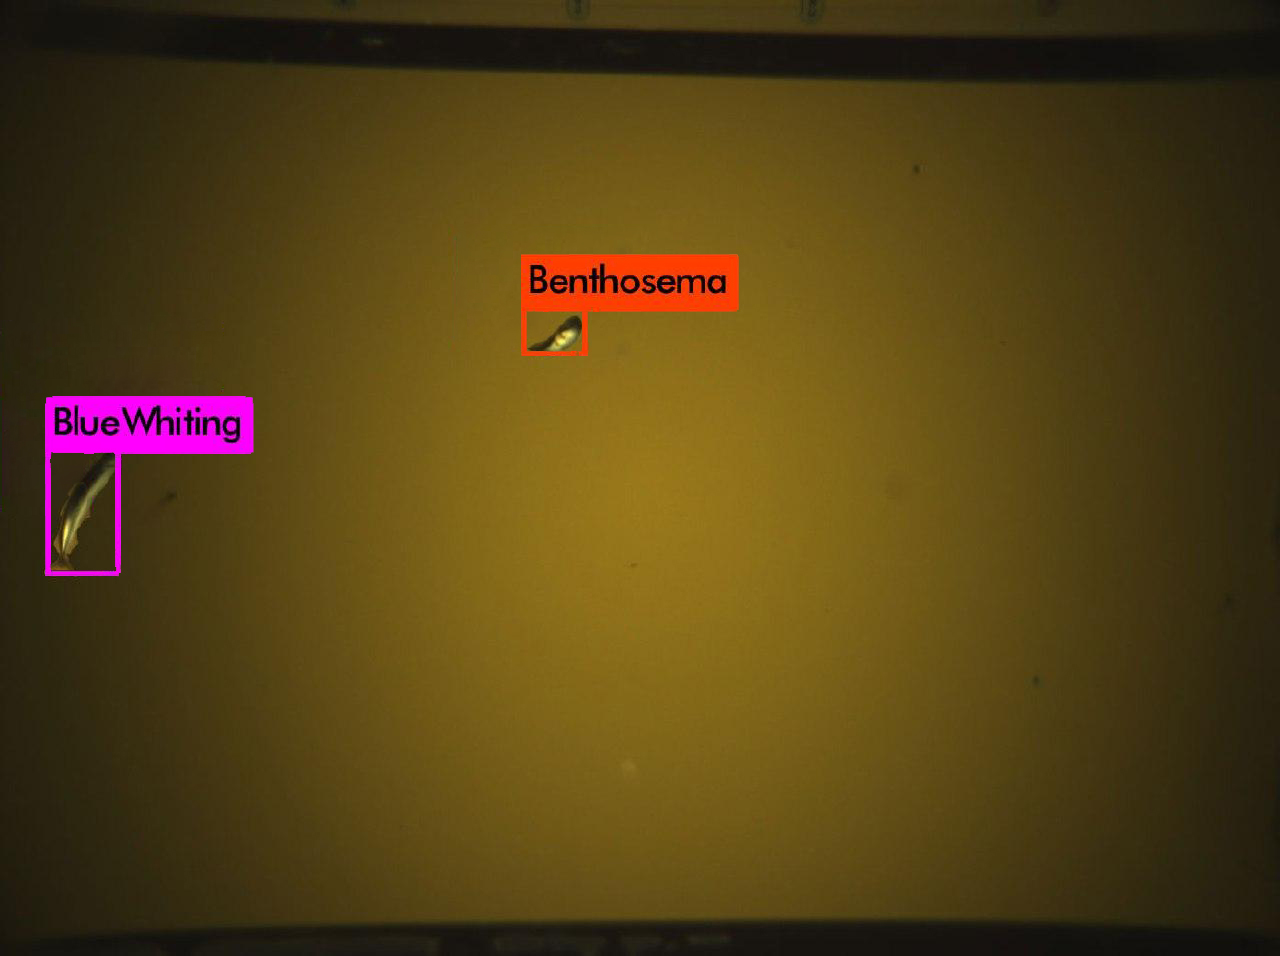
<br><br>
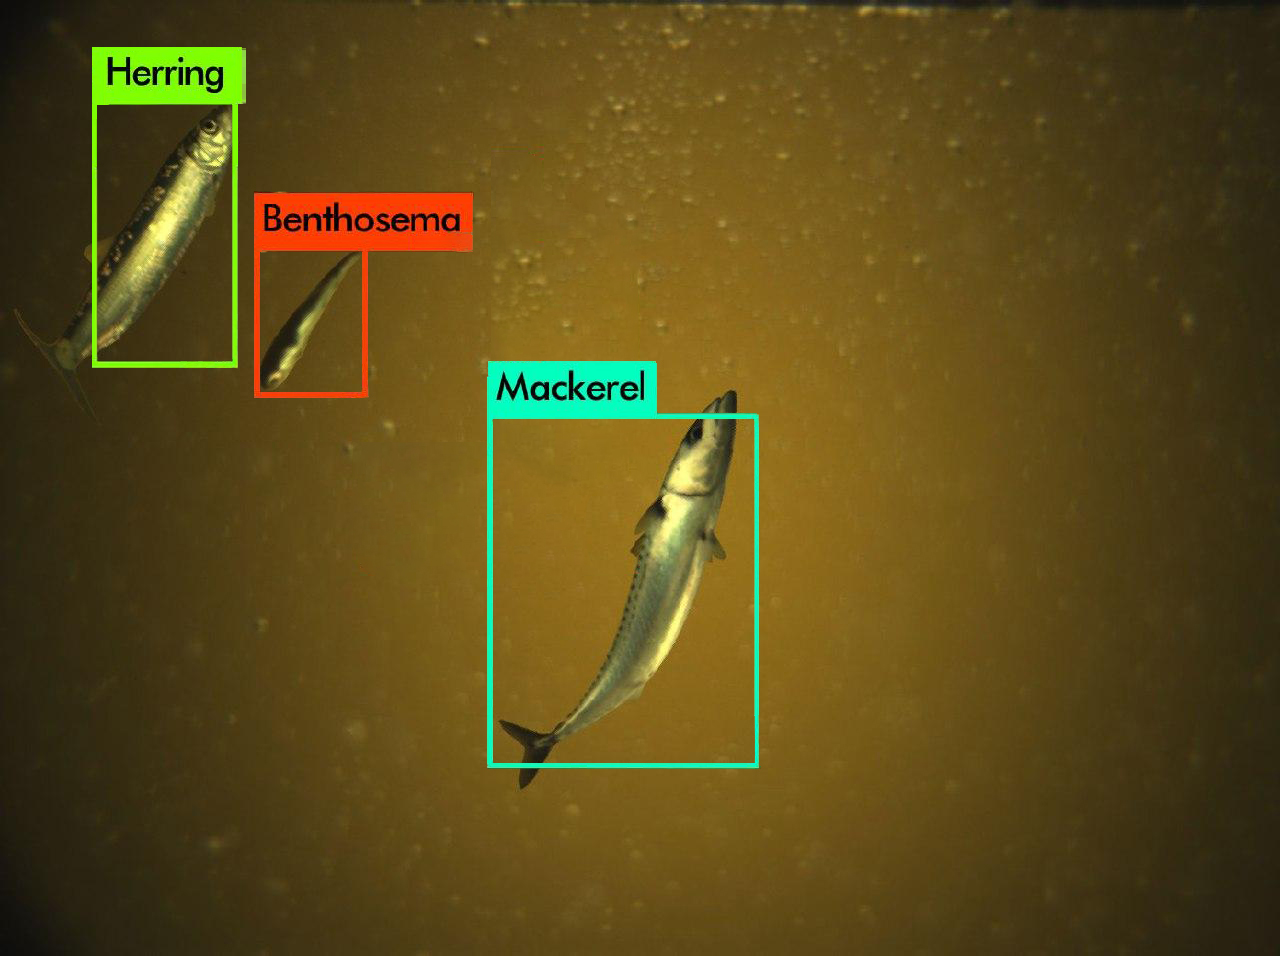
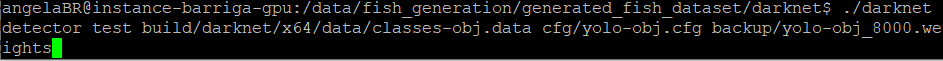

<h2>
Failed approach
</h2>

Same code as for Task 1 but adapted to the new data and output (4 outputs, one for each fish).

Some details:

<ul>
    <li>The first output is smaller than the rest because there's always at least one fish, and therefore there are 4 possibilities for classification (the fifth would be no fish).</li>
    <li>Some reasons for the poor performance of this attempt could be:</li>
    <ul>
        <li>Probably I didn't use enough data.</li>
        <li>The approach of cropping the images by their outter bounding boxes, including just relevant data, worked well with Task 1 because digits were in a row, but fishes are randomly distributed in the background, so it doesn't make much of a difference to crop the images.</li>
    </ul>
</ul>

In [0]:
import os
import cv2
import h5py
import math
import numpy as np
from PIL import Image
from scipy import misc
import random as rand
from operator import add
import pickle
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.patches
import glob
from tensorflow.python.framework import ops
from tensorflow.python.framework import dtypes
from tqdm import tqdm
from keras.utils import to_categorical

def getBBox(i, metadata):

    x_min = min(metadata['x'])
    y_min = min(metadata['y'])
    x_max = max(metadata['x'])
    y_max = max(metadata['y']) 
    width_max = max(metadata['width'])
    height_max = max(metadata['height'])

    x_max = x_max + width_max
    y_max = y_max + height_max
    
    return x_min, y_min, x_max, y_max


def expandBBox(x_min, y_min, x_max, y_max):

    x_d = int(((x_max - x_min) * 0.3) // 2)
    y_d = int(((y_max - y_min) * 0.3) // 2)
    return x_min - x_d, y_min - y_d, x_max + x_d, y_max + y_d


def cropBBox(img, x_min, y_min, x_max, y_max):
    try:
        cv2.resize(img[y_min:y_max, x_min:x_max], (512, 512))
    except:
        if(y_min < 0):
            y_min = 0
    try:
        cv2.resize(img[y_min:y_max, x_min:x_max], (512, 512))
    except:
        if(x_min < 0):
            x_min = 0
            
    return img[y_min:y_max, x_min:x_max]

def getResized(i, path, metadata):
        
    img = mpimg.imread(path + i + ".png")
    cropped =  cropBBox(img, (*expandBBox(*getBBox(i, metadata))))

    return cv2.resize(cropped, (512, 512))

def getRandomSmaller(img):
    
    x_min = rand.randint(0,10)
    x_max = 512 - (80 - x_min)
    y_min = rand.randint(0,10)
    y_max = 512 - (80 - y_min)
    return img[y_min:y_max, x_min:x_max]

def subtractMean(img):
    return img - np.mean(img)

def createAndSaveData(train=0, num_random_subsamples=4):
    
    im_array = []
    r0 = []
    r1 = []
    r2 = []
    r3 = []
    
    if train == 0:
        directory = path_train
        path = path_txt_train
        i_max = 3000
    if train == 1:
        directory = path_test
        path = path_txt_test
        i_max = 500
    if train == 2:
        directory = path_val
        path = path_txt_val
        i_max =500
    i = 0
    for filename in sorted(glob.glob(os.path.join(path, '*.txt'))):
        if i < i_max:
            print(i)
            with open(filename, 'r') as f:
                text = f.readlines()
                f.close()
            fn = filename[len(path):-4]
            print(fn)
            metadata = {}
            metadata['label'] = []
            metadata['x'] = []
            metadata['y'] = []
            metadata['width'] = []
            metadata['height'] = []
            for line in text: #Reading line-by-line
                words = line.split() #Splitting lines in words using space character as separator
                metadata['label'].append(int(words[1]))
                metadata['x'].append(int(words[2]))
                metadata['y'].append(int(words[3]))
                metadata['width'].append(int(words[4]))
                metadata['height'].append(int(words[5]))  

            img = getResized(fn, directory, metadata)
            im_array.append(subtractMean(img))
            a = metadata['label']
            label = []
            for n in a:
                label.append(n)
            while len(label) < 5:
                label.append(0)     
            r0.append(label[0])
            r1.append(label[1])
            r2.append(label[2])
            r3.append(label[3])
            i= i+1
        else:
            break
    return im_array,r0,r1,r2,r3


        
path_txt_test = '/data/fish_generation/generated_fish_dataset/test/texts/'
path_txt_train='/data/fish_generation/generated_fish_dataset/train/texts/'
path_txt_val ='/data/fish_generation/generated_fish_dataset/val/texts/'

path_train = "/data/fish_generation/generated_fish_dataset/train/images/"
path_test = "/data/fish_generation/generated_fish_dataset/test/images/"
path_val = "/data/fish_generation/generated_fish_dataset/val/images/"

x_train, y_train1, y_train2, y_train3, y_train4 = createAndSaveData(0, 4)
x_test, y_test1, y_test2, y_test3, y_test4 = createAndSaveData(1, 4)
x_val, y_val1, y_val2, y_val3, y_val4 = createAndSaveData(2, 4)

x_train = np.array(x_train)
x_test = np.array(x_test)
x_val = np.array(x_val)

y_train1 = np.array(y_train1)
y_train2 = np.array(y_train2)
y_train3 = np.array(y_train3)
y_train4 = np.array(y_train4)

y_test1 = np.array(y_test1)
y_test2 = np.array(y_test2)
y_test3 = np.array(y_test3)
y_test4 = np.array(y_test4)

y_val1 = np.array(y_val1)
y_val2 = np.array(y_val2)
y_val3 = np.array(y_val3)
y_val4 = np.array(y_val4)

y_train1 = to_categorical(y_train1, 5) #5 because there's always a fish here, so no 0s
y_train2 = to_categorical(y_train2, 6)
y_train3 = to_categorical(y_train3, 6)
y_train4 = to_categorical(y_train4, 6)

y_test1 = to_categorical(y_test1, 5)
y_test2 = to_categorical(y_test2, 6)
y_test3 = to_categorical(y_test3, 6)
y_test4 = to_categorical(y_test4, 6)

y_val1 = to_categorical(y_val1, 5)
y_val2 = to_categorical(y_val2, 6)
y_val3 = to_categorical(y_val3, 6)
y_val4 = to_categorical(y_val4, 6)

In [2]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K
from keras.optimizers import RMSprop
from keras.applications.inception_v3 import preprocess_input
from keras.callbacks import TensorBoard
from keras.layers import Input, Convolution2D, MaxPooling2D, Dropout, Flatten, MaxoutDense
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Activation, Dense
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

batch_size=64
gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         zoom_range = 0.1,
                         rotation_range = 40)

def gen_flow_for_four_inputs(x_train, y_train1, y_train2, y_train3, y_train4):
    genX1 = gen.flow(x_train, y_train1, batch_size=batch_size,seed=666)
    genX2 = gen.flow(x_train, y_train2, batch_size=batch_size,seed=666)
    genX3 = gen.flow(x_train, y_train3, batch_size=batch_size,seed=666)
    genX4 = gen.flow(x_train, y_train4, batch_size=batch_size,seed=666)
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            X3i = genX3.next()
            X4i = genX4.next()
        
            yield X1i[0], [X1i[1], X2i[1], X3i[1], X4i[1]]

base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.25, name="1drop")(x)
x = Dense(1000, activation=None, name="fc1")(x)
x = Dense(1000, activation=None, name="fc2")(x)
x = Dense(1000, activation=None, name="fc3")(x)

digit1 = Dense(5, activation="softmax", name="digit1")(x)
digit2 = Dense(6, activation="softmax", name="digit2")(x)
digit3 = Dense(6, activation="softmax", name="digit3")(x)
digit4 = Dense(6, activation="softmax", name="digit4")(x)

model = Model(input=base_model.input, output=[digit1, digit2, digit3, digit4])

for layer in base_model.layers:
    layer.trainable = False
    
model.compile(optimizer=RMSprop(0.0001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

gen_flow = gen_flow_for_four_inputs(x_train, y_train1, y_train2, y_train3, y_train4)

gen_flow_val = gen_flow_for_four_inputs(x_val, y_val1, y_val2, y_val3, y_val4)

model.fit_generator(gen_flow,
                    steps_per_epoch=len(x_train) / batch_size, epochs=5, validation_data=gen_flow_val,
                   validation_steps=len(x_val) / batch_size)

gen_flow_test = gen_flow_for_four_inputs(x_test, y_test1, y_test2, y_test3, y_test4)

results = model.evaluate(gen_flow_test, steps=len(x_test) / batch_size)
print(results)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:55: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("in...)`


Epoch 1/5
47/46 [==============================] - 593s 13s/step - loss: 5.8892 - digit1_loss: 1.5414 - digit2_loss: 1.7690 - digit3_loss: 1.6167 - digit4_loss: 0.9620 - digit1_categorical_accuracy: 0.2753 - digit2_categorical_accuracy: 0.2063 - digit3_categorical_accuracy: 0.4323 - digit4_categorical_accuracy: 0.7733 - val_loss: 5.6470 - val_digit1_loss: 1.3933 - val_digit2_loss: 1.6752 - val_digit3_loss: 1.4696 - val_digit4_loss: 0.9738 - val_digit1_categorical_accuracy: 0.3160 - val_digit2_categorical_accuracy: 0.2480 - val_digit3_categorical_accuracy: 0.4920 - val_digit4_categorical_accuracy: 0.7520
Epoch 2/5
47/46 [==============================] - 577s 12s/step - loss: 5.2701 - digit1_loss: 1.4181 - digit2_loss: 1.5900 - digit3_loss: 1.3801 - digit4_loss: 0.8818 - digit1_categorical_accuracy: 0.3187 - digit2_categorical_accuracy: 0.2947 - digit3_categorical_accuracy: 0.4960 - digit4_categorical_accuracy: 0.7733 - val_loss: 5.5331 - val_digit1_loss: 1.3764 - val_digit2_loss: 1.536